In [8]:
import os
import torchaudio
import numpy as np
import torch
from tqdm import tqdm
import einops

In [2]:
from datasets import load_dataset, Audio
from transformers import EncodecModel, AutoProcessor


# load a demonstration datasets
librispeech_dummy = load_dataset("hf-internal-testing/librispeech_asr_dummy", "clean", split="validation")

# load the model + processor (for pre-processing the audio)
model = EncodecModel.from_pretrained("facebook/encodec_24khz")
processor = AutoProcessor.from_pretrained("facebook/encodec_24khz")

# cast the audio data to the correct sampling rate for the model
librispeech_dummy = librispeech_dummy.cast_column("audio", Audio(sampling_rate=processor.sampling_rate))
audio_sample = librispeech_dummy[0]["audio"]["array"]

# pre-process the inputs
inputs = processor(raw_audio=audio_sample, sampling_rate=processor.sampling_rate, return_tensors="pt")

# explicitly encode then decode the audio inputs
encoder_outputs = model.encode(inputs["input_values"], inputs["padding_mask"])
audio_values = model.decode(encoder_outputs.audio_codes, encoder_outputs.audio_scales, inputs["padding_mask"])[0]

# or the equivalent with a forward pass
audio_values = model(inputs["input_values"], inputs["padding_mask"]).audio_values


/home/ckadirt/miniconda3/envs/b2m/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [25]:
def get_encoder_outputs(paths):
    input_values = []
    padding_masks = []
    for path in paths:
        audio_loaded, sr = torchaudio.load(path)
        audio_loaded = torchaudio.transforms.Resample(sr, 24000)(audio_loaded)
        #print(audio_loaded.shape)
        # take just the 0.1333333 part of the audio
        audio_loaded = audio_loaded[:, int(audio_loaded.shape[1] * 0.133333333):int(audio_loaded.shape[1] * 0.133333333) * 2]
        #print(audio_loaded.shape)
        audio_sample = processor(raw_audio=audio_loaded[0], sampling_rate=24000, return_tensors="pt")
        input_values.append(audio_sample["input_values"])
        padding_masks.append(audio_sample["padding_mask"])
    
    input_values = torch.cat(input_values, dim=0)
    padding_masks = torch.cat(padding_masks, dim=0)
    sr = 24000
    encoder_outputs = model.encode(input_values, padding_masks)
    return encoder_outputs, audio_sample

def get_reconstructed_audio(encoder_outputs, audio_sample):
    print(encoder_outputs.audio_codes.shape)
    print(audio_sample["padding_mask"].shape)
    audio_values = model.decode(encoder_outputs.audio_codes, encoder_outputs.audio_scales, audio_sample["padding_mask"])[0]
    return audio_values


embeddings, another_info = get_encoder_outputs(['/home/ckadirt/brain2music/dataset/preproc/genres_preproc/Stim_Test_Run01_30_pop.wav'])
reconstructed = get_reconstructed_audio(embeddings, another_info)

torch.Size([1, 1, 2, 150])
torch.Size([1, 47999])


In [4]:
reconstructed = reconstructed[0]
print(reconstructed.shape)
torchaudio.save('first2second.wav', reconstructed, 24000)

torch.Size([1, 47999])


In [34]:
# read this tokens /home/ckadirt/Downloads/outputs_train397.pt
tokens = torch.load('/home/ckadirt/Downloads/outputs_train397.pt', map_location=torch.device('cpu'))
tokens.shape
# first song
first_song = einops.rearrange(tokens[152], '(u u2 c c1)-> u2 u c c1', c=2, u=1, u2=1)
first_song.shape

torch.Size([1, 1, 2, 150])

In [35]:
# reconstruct
reconstructed = model.decode(first_song, [None], torch.ones(torch.Size([1, 47999])))

In [36]:
reconstructed.audio_values.shape
# save the reconstructed audio
torchaudio.save('train_reconstructed.wav', reconstructed.audio_values[0], 24000)


In [96]:
another_info.input_values.shape

torch.Size([1, 1, 360000])

In [44]:
wav_paths = '/home/ckadirt/brain2music/dataset/preproc/genres_preproc'

# get a list of all the wav files
wav_files = [os.path.join(wav_paths, f) for f in os.listdir(wav_paths) if f.endswith(".wav")]

# if the path has Training in it, it's a training file
training_wav_files = [f for f in wav_files if "Training" in f]
test_wav_files = [f for f in wav_files if "Test" in f]


def get_embeddings(audios_paths):
    embeddings = torch.zeros((len(audios_paths), 2, 150))
    for i, path in tqdm(enumerate(audios_paths)):
        encoder_outputs, audio_sample = get_encoder_outputs([path])
        if (encoder_outputs.audio_codes.shape != (1, 1, 2, 150)):
            print("There's a problem with the audio: ", path)
            print("The shape is: ", encoder_outputs.audio_codes.shape)
        embeddings[i] = encoder_outputs.audio_codes[0][0]
    return embeddings

training_embeds = get_embeddings(training_wav_files)


480it [00:52,  9.19it/s]


In [45]:
test_embeds = get_embeddings(test_wav_files)

240it [00:27,  8.68it/s]


In [46]:
test_embeds

tensor([[[ 507.,  948.,  532.,  ...,  974.,  912.,  263.],
         [ 945.,  612., 1000.,  ...,  285.,  509.,  432.]],

        [[ 926.,  685.,  988.,  ...,  580.,  478.,  485.],
         [ 973.,  973.,  447.,  ...,  555.,  101.,  555.]],

        [[ 511.,  916.,  372.,  ...,  974.,  974.,  974.],
         [ 761.,  973.,  197.,  ...,  764.,  764.,  594.]],

        ...,

        [[ 213.,  830.,  830.,  ...,  375.,  567.,  548.],
         [ 779.,  330.,  435.,  ...,  685.,  264.,  264.]],

        [[  38.,  511.,  731.,  ...,  246.,  806.,  891.],
         [ 370.,  908.,  370.,  ...,  269.,  902.,  898.]],

        [[ 302.,  244.,  660.,  ...,  951.,  962.,  485.],
         [ 963.,  645.,  645.,  ...,  655.,  163.,   81.]]])

In [47]:
# save the training embeddings
np.save("encodec_training_embeds_150.npy", training_embeds)
np.save("encodec_test_embeds_150.npy", test_embeds)

In [124]:
train_dir = '/home/ckadirt/brain2music/dataset/Gtanz/audios/sub-001/train'
audios_train_paths = os.listdir(train_dir)

test_dir = '/home/ckadirt/brain2music/dataset/Gtanz/audios/sub-001/test'
audios_test_paths = os.listdir(test_dir)

def get_embeddings(audios_paths):
    embeddings = torch.zeros((len(audios_paths), 2, 1125))
    for i, path in tqdm(enumerate(audios_paths)):
        embeddings_s, another_info = get_encoder_outputs([path])
        if (embeddings_s.audio_codes.shape != (1,1,2,1125)):
            print("There's a problem with the audio: ", path)
            print("The shape is: ", embeddings_s.audio_codes.shape)
        embeddings[i] = embeddings_s.audio_codes[0][0][0][:][:1125]

    return embeddings

In [27]:
embed = torch.Tensor([ 408.,  395.,   25.,  537.,  537.,  999.,  228.,  537.,  731.,  753.,
         499.,  999.,  325.,  731.,  834.,  499.,  731., 1011.,  731.,  228.,
         731.,  677.,  666.,  860.,  495.,  409.,  602.,  783.,  731.,  192.,
         977.,  843.,  192.,  602.,  731.,  731.,  740.,  461.,  461.,  957.,
         461.,  511.,  497.,  511.,  854.,  872.,  213.,  729.,  335.,  764.,
         731.,  777.,  237.,  598.,  666.,  627.,  327.,  972.,  246.,  461.,
         307.,  246.,  330.,  511.,  602.,  806.,  246.,  372.,  513.,  729.,
         729.,  854.,  246.,  511.,  788.,  788.,  854.,  788.,  492.,  513.,
         729.,  541.,   13.,  854.,  740.,  731.,  549.,  806.,  144.,  372.,
         329., 1023.,  788.,  854.,  511.,  645.,  854.,  361.,  854.,  854.,
         789.,  602.,  628.,  790.,  789.,  951.,  368.,  329.,  900.,  650.,
         400.,  951.,  654.,  915.,  157.,  659.,  141.,  420.,  729.,  157.,
         854.,  715.,  788.,  511.,  246.,  804.,  335.,  307.,  854.,  263.,
         854.,  970.,  800.,  154.,  385., 1008.,  580.,  854.,  226.,  246.,
         335.,  790.,  715.,  789.,  854.,  679.,  833.,  806.,  923.,  854.,
         854.,  729.,  740.,  573.,  167.,  226.,  480.,  385.,  341.,  715.,
         843.,  226.,  602.,  854.,  854.,   33., 1023.,    4.,  683.,  361.,
         801.,  329.,  854.,  431.,  891.,  335.,  335.,  854.,  854.,  650.,
         645.,  580.,  997.,  854.,  132.,  329.,  854.,  573.,  951.,  368.,
         715.,  814.,  330.,  564.,  541.,  603.,  735.,  960.,  729.,  659.])
embed.unsqueeze_(0)
embed = torch.cat([embed, embed], dim=0)
embed.unsqueeze_(0)
embed.unsqueeze_(0)
embed = embed.int()
print(embed.shape)
model.eval()
with torch.no_grad():
    audio = model.decode(embed, audio_scales=[None], padding_mask=torch.ones(1,360000))[0][0]
    print(audio.shape)
    torchaudio.save('test.wav', audio, 24000)

torch.Size([1, 1, 2, 200])
torch.Size([1, 64000])


In [130]:
# get the audio_path 73
audio_path_73 = os.path.join(train_dir, audios_train_paths[73])
# get its embeddings
embeddings_73 = get_embeddings([audio_path_73])

1it [00:00,  1.87it/s]

There's a problem with the audio:  /home/ckadirt/brain2music/dataset/Gtanz/audios/sub-001/train/00285-pop-8.wav
The shape is:  torch.Size([1, 1, 2, 1126])


In [129]:
embeddings_73.shape

torch.Size([1, 2, 1125])

In [131]:
print('Getting embeddings for train audios...')
train_embeddings = get_embeddings([os.path.join(train_dir, path) for path in audios_train_paths])
print('Getting embeddings for test audios...')
test_embeddings = get_embeddings([os.path.join(test_dir, path) for path in audios_test_paths])

Getting embeddings for train audios...


74it [00:36,  2.05it/s]

There's a problem with the audio:  /home/ckadirt/brain2music/dataset/Gtanz/audios/sub-001/train/00285-pop-8.wav
The shape is:  torch.Size([1, 1, 2, 1126])


117it [00:56,  2.14it/s]

There's a problem with the audio:  /home/ckadirt/brain2music/dataset/Gtanz/audios/sub-001/train/00449-jazz-13.wav
The shape is:  torch.Size([1, 1, 2, 1126])


131it [01:03,  2.14it/s]

There's a problem with the audio:  /home/ckadirt/brain2music/dataset/Gtanz/audios/sub-001/train/00247-disco-12.wav
The shape is:  torch.Size([1, 1, 2, 1126])


179it [01:25,  2.17it/s]

There's a problem with the audio:  /home/ckadirt/brain2music/dataset/Gtanz/audios/sub-001/train/00381-metal-6.wav
The shape is:  torch.Size([1, 1, 2, 1126])


274it [02:09,  2.16it/s]

There's a problem with the audio:  /home/ckadirt/brain2music/dataset/Gtanz/audios/sub-001/train/00419-blues-38.wav
The shape is:  torch.Size([1, 1, 2, 1126])


289it [02:16,  2.16it/s]

There's a problem with the audio:  /home/ckadirt/brain2music/dataset/Gtanz/audios/sub-001/train/00065-country-46.wav
The shape is:  torch.Size([1, 1, 2, 1126])


308it [02:25,  2.15it/s]

There's a problem with the audio:  /home/ckadirt/brain2music/dataset/Gtanz/audios/sub-001/train/00028-pop-92.wav
The shape is:  torch.Size([1, 1, 2, 1126])


316it [02:28,  2.15it/s]

There's a problem with the audio:  /home/ckadirt/brain2music/dataset/Gtanz/audios/sub-001/train/00077-rock-76.wav
The shape is:  torch.Size([1, 1, 2, 1126])


437it [03:25,  2.17it/s]

There's a problem with the audio:  /home/ckadirt/brain2music/dataset/Gtanz/audios/sub-001/train/00212-rock-91.wav
The shape is:  torch.Size([1, 1, 2, 1126])


440it [03:26,  2.15it/s]

There's a problem with the audio:  /home/ckadirt/brain2music/dataset/Gtanz/audios/sub-001/train/00313-disco-30.wav
The shape is:  torch.Size([1, 1, 2, 1126])


442it [03:27,  2.12it/s]

There's a problem with the audio:  /home/ckadirt/brain2music/dataset/Gtanz/audios/sub-001/train/00273-jazz-99.wav
The shape is:  torch.Size([1, 1, 2, 1126])


457it [03:34,  2.14it/s]

There's a problem with the audio:  /home/ckadirt/brain2music/dataset/Gtanz/audios/sub-001/train/00356-reggae-9.wav
The shape is:  torch.Size([1, 1, 2, 1126])


473it [03:42,  2.13it/s]

There's a problem with the audio:  /home/ckadirt/brain2music/dataset/Gtanz/audios/sub-001/train/00135-country-95.wav
The shape is:  torch.Size([1, 1, 2, 1126])


480it [03:45,  2.13it/s]


Getting embeddings for test audios...


2it [00:00,  2.09it/s]

There's a problem with the audio:  /home/ckadirt/brain2music/dataset/Gtanz/audios/sub-001/test/00078-blues-40.wav
The shape is:  torch.Size([1, 1, 2, 1126])


27it [00:12,  2.11it/s]

There's a problem with the audio:  /home/ckadirt/brain2music/dataset/Gtanz/audios/sub-001/test/00058-blues-40.wav
The shape is:  torch.Size([1, 1, 2, 1126])


51it [00:24,  2.12it/s]

There's a problem with the audio:  /home/ckadirt/brain2music/dataset/Gtanz/audios/sub-001/test/00048-blues-40.wav
The shape is:  torch.Size([1, 1, 2, 1126])


116it [00:55,  2.10it/s]

There's a problem with the audio:  /home/ckadirt/brain2music/dataset/Gtanz/audios/sub-001/test/00068-blues-40.wav
The shape is:  torch.Size([1, 1, 2, 1126])


124it [00:59,  2.07it/s]

There's a problem with the audio:  /home/ckadirt/brain2music/dataset/Gtanz/audios/sub-001/test/00011-pop-32.wav
The shape is:  torch.Size([1, 1, 2, 1126])


175it [01:23,  2.08it/s]

There's a problem with the audio:  /home/ckadirt/brain2music/dataset/Gtanz/audios/sub-001/test/00021-pop-32.wav
The shape is:  torch.Size([1, 1, 2, 1126])


202it [01:36,  2.10it/s]

There's a problem with the audio:  /home/ckadirt/brain2music/dataset/Gtanz/audios/sub-001/test/00001-pop-32.wav
The shape is:  torch.Size([1, 1, 2, 1126])


236it [01:52,  2.09it/s]

There's a problem with the audio:  /home/ckadirt/brain2music/dataset/Gtanz/audios/sub-001/test/00031-pop-32.wav
The shape is:  torch.Size([1, 1, 2, 1126])


240it [01:54,  2.09it/s]


In [132]:
# save the embeddings
torch.save(train_embeddings, '/home/ckadirt/brain2music/dataset/Gtanz/audios/sub-001/encodec_embeddings_train.pt')
torch.save(test_embeddings, '/home/ckadirt/brain2music/dataset/Gtanz/audios/sub-001/encodec_embeddings_test.pt')

In [135]:
test_embeddings.shape

torch.Size([240, 2, 1125])

In [ ]:
# save the train embeddings
np.save('train_embeddings_encodec.npy', train_embeddings)


In [79]:


# recunstruct and save the first audio
torchaudio.save("reconstructed1.wav", reconstructed[0], 24000)
# now the second
torchaudio.save("reconstructed2.wav", reconstructed[1], 24000)

In [58]:
# get the mean, std, and max of the audio values
print(audio_values.mean(), audio_values.std(), audio_values.max())
# get the mean, std, and max of the audio codes
print(embeddings.audio_codes.float().mean(), embeddings.audio_codes.float().std(), embeddings.audio_codes.float().max(), embeddings.audio_codes.float().min())

tensor(-2.5186e-05, grad_fn=<MeanBackward0>) tensor(0.0567, grad_fn=<StdBackward0>) tensor(0.5089, grad_fn=<MaxBackward1>)
tensor(562.4698) tensor(292.6277) tensor(1023.) tensor(0.)


In [55]:
# change random values in the audio codes with a n% probability (the random values are between 0 and 1023 integers)
# this is to simulate a bit error rate

def randomizeEmbeddings(embeddings, error):
    # make a copy of the embeddings to modify
    embeddings_copy = embeddings.copy()
    embeddingsTensor = embeddings_copy.audio_codes
    # get a random mask of the same shape as the embeddings tensor
    mask = torch.rand(embeddingsTensor.shape) < error
    # get a random tensor of the same shape as the embeddings tensor
    randomTensor = torch.randint_like(embeddingsTensor, 0, 1024)
    # apply the mask to the random tensor
    randomTensor = randomTensor * mask
    # apply the mask to the embeddings tensor
    embeddingsTensor = embeddingsTensor * (~mask)
    # add the random tensor to the embeddings tensor
    embeddingsTensor = embeddingsTensor + randomTensor
    # return the embeddings tensor
    embeddings_copy.audio_codes = embeddingsTensor
    return embeddings_copy

noised_embeddings = randomizeEmbeddings(embeddings, 0.4)



In [56]:
reconstructed_noised = get_reconstructed_audio(noised_embeddings, another_info)
# save the audio
torchaudio.save("reconstructed_noised.wav", reconstructed_noised[0].detach().cpu(), 24000)

In [59]:
embeddings.audio_codes.shape

torch.Size([1, 1, 2, 1125])

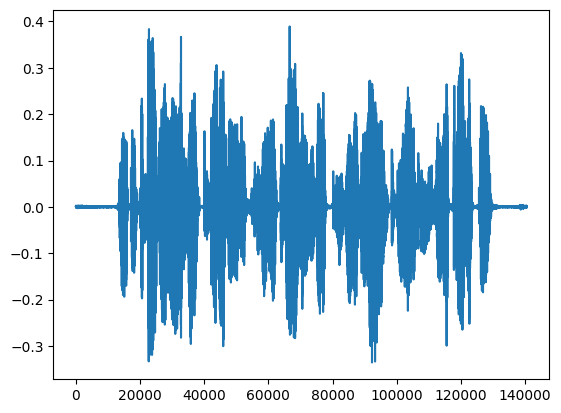

In [11]:
audio_sample.shape
# plot the original audio
import matplotlib.pyplot as plt
plt.plot(audio_sample)
plt.show()

# save the original audio
import torchaudio
import torch
torchaudio.save("original.wav", torch.tensor(audio_sample).unsqueeze(0).float(), processor.sampling_rate)

In [13]:
print(processor.sampling_rate)

24000


In [12]:
import torchaudio 
import IPython

audio_values_single = audio_values[0][0].detach().cpu().numpy()
audio_values_single.shape

# display the original audio
torchaudio.save("original.wav", torch.tensor(audio_sample).unsqueeze(0).float(), processor.sampling_rate)
IPython.display.Audio("original.wav")

# display the reconstructed audio
torchaudio.save("reconstructed.wav", torch.tensor(audio_values_single).unsqueeze(0).float(), processor.sampling_rate)
IPython.display.Audio("reconstructed.wav")